### Metadata

In [1]:
%cd ..

/Users/davidrestrepo/Data Fusion/DF-DM


In [2]:
from src.Preprocessing.time_series_preprocessing import get_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor
from src.Preprocessing.time_series_preprocessing import read_static, read_features
from src.Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np
import random
import tensorflow as tf
import torch

def set_all_seeds(seed):
    """
    Set seed for reproducibility in different libraries.
    :param seed: An integer representing the seed value.
    """
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # Numpy library
    os.environ['PYTHONHASHSEED'] = str(seed)  # Environment variable

    # TensorFlow
    tf.random.set_seed(seed)
    if tf.__version__[0] == '2':
        # For TensorFlow 2.x, additionally set the global random seed
        tf.compat.v1.set_random_seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        # If using GPU with PyTorch, set additional seeds
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU

In [3]:
DIR_PATH = 'datasets/violence_prediction/'
file = 'metadata_labels.csv'
cohort = 'cities.csv'

In [4]:
cities = pd.read_csv(DIR_PATH + cohort)
cities

,lat,lng,Municipality,Municipality code,ISO
0,6.2447,-75.5748,Medellín,5001,CO-ANT
1,3.4400,-76.5197,Cali,76001,CO-VAC
2,4.5781,-74.2144,Soacha,25754,CO-CUN
3,4.1425,-73.6294,Villavicencio,50001,CO-MET
4,1.2136,-77.2811,Pasto,52001,CO-NAR
5,10.9639,-74.7964,Barranquilla,8001,CO-ATL
6,7.1186,-73.1161,Bucaramanga,68001,CO-SAN
7,4.4378,-75.2006,Ibagué,73001,CO-TOL
8,2.4411,-76.6061,Popayán,19001,CO-CAU
9,7.9075,-72.5047,Cúcuta,54001,CO-NSA


##### Constants

In [5]:
""" Read Dataset:"""
image_embeddings = None #'Embeddings/Embeddings_dinov2_large.csv'
media_data = 'datasets/violence_prediction/internet_data.csv'
static = 'datasets/violence_prediction/metadata_labels.csv'

DIR_PATH = 'datasets/violence_prediction/'
file = 'metadata_labels.csv'
labels = pd.read_csv(DIR_PATH + file)

# Get list of municipalities:
cohort = 'cities.csv'
cities = pd.read_csv(DIR_PATH + cohort)
Municipalities = cities.Municipality.values

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

seed = 1
n_tests = 3

### Read and Preprocess the Data

#### Read the Data

In [6]:
# Read dataset
dengue_df = [get_dataset(labels_path=labels, embeddings_path=image_embeddings, municipality=Municipality, temp_prec=media_data, static=static) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of Medellín only...
Obtaining dataframe for the city of Cali only...
Obtaining dataframe for the city of Soacha only...
Obtaining dataframe for the city of Villavicencio only...
Obtaining dataframe for the city of Pasto only...
Obtaining dataframe for the city of Barranquilla only...
Obtaining dataframe for the city of Bucaramanga only...
Obtaining dataframe for the city of Ibagué only...
Obtaining dataframe for the city of Popayán only...
Obtaining dataframe for the city of Cúcuta only...


list

#### Train-Test Split

In [8]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
    

The train shape is: (187, 34)
The test shape is: (47, 34)
The train shape is: (145, 34)
The test shape is: (37, 34)
The train shape is: (206, 34)
The test shape is: (52, 34)
The train shape is: (32, 34)
The test shape is: (8, 34)
The train shape is: (131, 34)
The test shape is: (33, 34)
The train shape is: (150, 34)
The test shape is: (38, 34)
The train shape is: (112, 34)
The test shape is: (28, 34)
The train shape is: (80, 34)
The test shape is: (20, 34)
The train shape is: (80, 34)
The test shape is: (21, 34)
The train shape is: (127, 34)
The test shape is: (32, 34)


#### Normalize the Data

In [9]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [10]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

train_df[1].head()

Violencia  violencia de genero     Count  NumMentions  \
Cali 201801  -1.340076            -0.826367 -0.505233    -0.294933   
     201802  -1.597822            -0.779925 -0.505233    -0.314382   
     201803  -0.979230            -0.222624 -0.594182    -0.327349   
     201804  -0.927681             0.056027 -0.594182    -0.327349   
     201805  -0.618385            -0.826367  0.473211     0.158890   

             NumSources  NumArticles   AvgTone  Age0-4(%)  Age5-14(%)  \
Cali 201801   -0.310338    -0.293099 -0.164350   -1.07607   -0.956006   
     201802   -0.310338    -0.313049 -1.061408   -1.07607   -0.956006   
     201803   -0.328601    -0.326350  1.637157   -1.07607   -0.956006   
     201804   -0.328601    -0.326350  1.637157   -1.07607   -0.956006   
     201805    0.073183     0.105907 -0.923627   -1.07607   -0.956006   

             Age15-29(%)  ...  Buildingstratification1(%)  \
Cali 201801    -1.524918  ...                    -0.58877   
     201802    -1.524918  ...                    -0.58877   
     201803    -1.524918  ...                    -0.58877   
     201804    -1.524918  ...                    -0.58877   
     201805    -1.524918  ...                    -0.58877   

             Buildingstratification2(%)  Buildingstratification3(%)  \
Cali 201801                   -0.495713                    0.484871   
     201802                   -0.495713                    0.484871   
     201803                   -0.495713                    0.484871   
     201804                   -0.495713                    0.484871   
     201805                   -0.495713                    0.484871   

             Buildingstratification4(%)  Buildingstratification5(%)  \
Cali 201801                    0.219844                    1.553038   
     201802                    0.219844                    1.553038   
     201803                    0.219844                    1.553038   
     201804                    0.219844                    1.553038   
     201805                    0.219844                    1.553038   

             Buildingstratification6(%)  NumberofhospitalsperKm2  \
Cali 201801                    0.486149                 -0.01718   
     201802                    0.486149                 -0.01718   
     201803                    0.486149                 -0.01718   
     201804                    0.486149                 -0.01718   
     201805                    0.486149                 -0.01718   

             NumberofhousesperKm2  population    Labels  
Cali 201801              0.130085    1.430892  0.426469  
     201802              0.130085    1.430892 -0.023963  
     201803              0.130085    1.430892  0.253226  
     201804              0.130085    1.430892  0.807604  
     201805              0.130085    1.430892  0.339848  

[5 rows x 34 columns]

In [11]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

Violencia  violencia de genero     Count  NumMentions  \
Cali 202135   0.154854            -0.779925 -0.594182    -0.311141   
     202138   0.721896             0.334678 -0.149435    -0.262517   
     202146   0.979643             0.613329 -0.505233    -0.291691   
     202147   1.288939             1.449282 -0.327334    -0.294933   
     202148  -1.082329             0.056027 -0.060486    -0.217135   

             NumSources  NumArticles   AvgTone  Age0-4(%)  Age5-14(%)  \
Cali 202135   -0.310338    -0.309724  0.020257   -1.07607   -0.956006   
     202138   -0.219024    -0.259849 -0.164755   -1.07607   -0.956006   
     202146   -0.292076    -0.289774 -1.089343   -1.07607   -0.956006   
     202147   -0.255550    -0.293099  0.010196   -1.07607   -0.956006   
     202148   -0.200761    -0.213298 -0.907325   -1.07607   -0.956006   

             Age15-29(%)  ...  Buildingstratification1(%)  \
Cali 202135    -1.524918  ...                    -0.58877   
     202138    -1.524918  ...                    -0.58877   
     202146    -1.524918  ...                    -0.58877   
     202147    -1.524918  ...                    -0.58877   
     202148    -1.524918  ...                    -0.58877   

             Buildingstratification2(%)  Buildingstratification3(%)  \
Cali 202135                   -0.495713                    0.484871   
     202138                   -0.495713                    0.484871   
     202146                   -0.495713                    0.484871   
     202147                   -0.495713                    0.484871   
     202148                   -0.495713                    0.484871   

             Buildingstratification4(%)  Buildingstratification5(%)  \
Cali 202135                    0.219844                    1.553038   
     202138                    0.219844                    1.553038   
     202146                    0.219844                    1.553038   
     202147                    0.219844                    1.553038   
     202148                    0.219844                    1.553038   

             Buildingstratification6(%)  NumberofhospitalsperKm2  \
Cali 202135                    0.486149                 -0.01718   
     202138                    0.486149                 -0.01718   
     202146                    0.486149                 -0.01718   
     202147                    0.486149                 -0.01718   
     202148                    0.486149                 -0.01718   

             NumberofhousesperKm2  population    Labels  
Cali 202135              0.130085    1.430892  0.928875  
     202138              0.130085    1.430892  1.396631  
     202146              0.130085    1.430892  0.582388  
     202147              0.130085    1.430892  0.824929  
     202148              0.130085    1.430892  0.183929  

[5 rows x 34 columns]

#### Prepare data for time series supervised learning (function to create sliding window)

In [12]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(143, 100)

#### Merge

In [13]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

train.shape

(1230, 100)

#### Features and Labels Set

In [14]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1230, 99)
The shape of the labels is (1230, 1)
Test:
The shape of the features is (296, 99)
The shape of the labels is (296, 1)


In [15]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1230, 99)
The test shape is (296, 99)
-----------------------
The Final shapes are:
The train shape is (1230, 3, 33)
The test shape is (296, 3, 33)


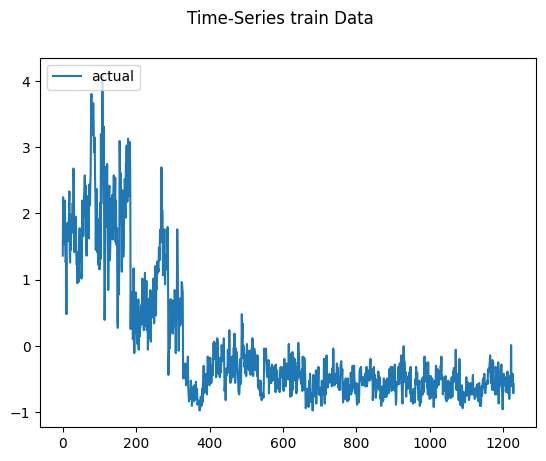

2024-01-16 17:10:04.079083: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-16 17:10:04.079158: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-16 17:10:04.079170: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-16 17:10:04.083350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-16 17:10:04.083391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-01-16 17:10:09.435345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:10:10.272729: I te

Restoring model weights from the end of the best epoch: 10.
Epoch 18: early stopping


2024-01-16 17:11:27.872451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:11:28.179504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:11:28.308704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 322ms/step
Test MAE: 29.344
Test RMSE: 38.633
Test sMAPE: 47.630
Test R Squared: 0.447
{'mae': 29.344055207999975, 'rmse': 38.633481274768606, 'smape': 47.630293631535565, 'r2': 0.4469757583626811}


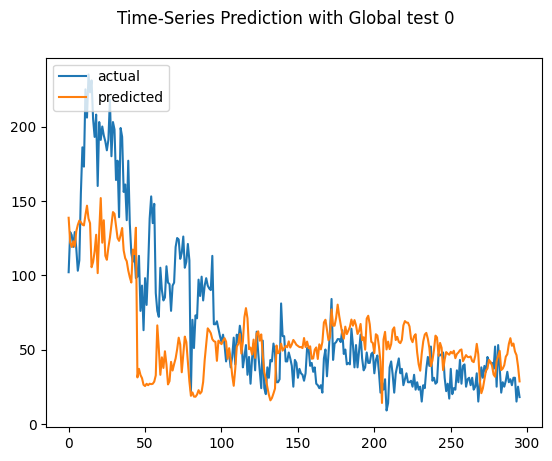

2024-01-16 17:11:45.371835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:11:46.054793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:11:46.217425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:11:47.036907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:11:47.464290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:11:58.801055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:11:59.046560: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping


2024-01-16 17:12:35.008977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:12:35.376844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:12:35.568415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 2s 35ms/step
Test MAE: 33.679
Test RMSE: 45.699
Test sMAPE: 49.276
Test R Squared: 0.226
{'mae': 33.67892323313533, 'rmse': 45.6992669187655, 'smape': 49.27574520986524, 'r2': 0.2261889144480207}


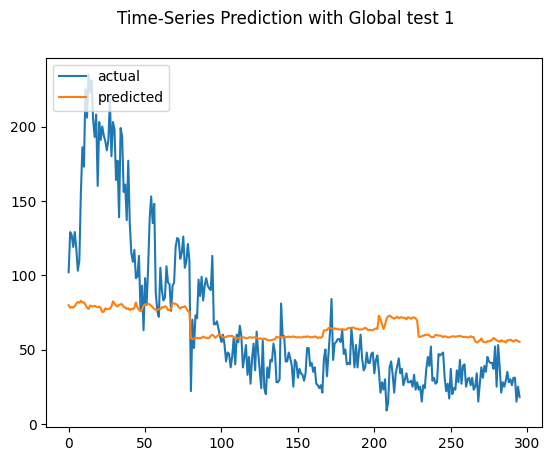

2024-01-16 17:12:43.157574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:12:43.696754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:12:43.815705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:12:44.646617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:12:44.838770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:12:57.127179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:13:01.405213: I tensorflow/core/grappler/optimizers/cust

In [16]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

set_all_seeds(1)
calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=n_tests, plot_samples=True, Municipality='Global')

### Late Fusion Model

In [ ]:
set_all_seeds(1)

x_ar = train_X[:, :, :7]
x_ar_test = test_X[:, :, :10724]
train_X = train_X[:, :, 1024:]
test_X = test_X[:, :, 1024:]

results = calculate_mean_std(lstm_layers, nn_layers, sequence, train_X.shape[2], dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers_list['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=n_tests, plot_samples=True, Municipality='Global', fusion='late', x_ar=x_ar, x_ar_test=x_ar_test)
results_list_late.append(results)